In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Loading Dataset

In [4]:
train_df=pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print("\nTrain head:")
print(train_df.head())

print("\nTest head:")
print(test_df.head())

Train shape: (120000, 3)
Test shape: (7600, 3)

Train head:
   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  

Test head:
   Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1            4  The Race is On: Second Privat

1) Preprocessing

In [7]:
import re
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemm.lemmatize(t) for t in tokens]
    return " ".join(tokens)

train_df['text'] = train_df['Title'].astype(str) + " " + train_df['Description'].astype(str)
test_df['text'] = test_df['Title'].astype(str) + " " + test_df['Description'].astype(str)

train_df['clean_text'] = train_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)

print(train_df[['text', 'clean_text']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                text  \
0  Wall St. Bears Claw Back Into the Black (Reute...   
1  Carlyle Looks Toward Commercial Aerospace (Reu...   
2  Oil and Economy Cloud Stocks' Outlook (Reuters...   
3  Iraq Halts Oil Exports from Main Southern Pipe...   
4  Oil prices soar to all-time record, posing new...   

                                          clean_text  
0  wall st bear claw back black reuters reuters s...  
1  carlyle look toward commercial aerospace reute...  
2  oil economy cloud stock outlook reuters reuter...  
3  iraq halt oil export main southern pipeline re...  
4  oil price soar time record posing new menace u...  


Converting clean text to TF-IDF vectors

encoding labels

In [8]:
le = LabelEncoder()
y_train = le.fit_transform(train_df['Class Index'])

tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_df['clean_text'])
X_test = tfidf.transform(test_df['clean_text'])

Training XGBClassifier

In [9]:
model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:26:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Predictions from training set

In [11]:
y_pred = model.predict(X_train)

Evaluation

In [13]:
print("Accuracy:\n", accuracy_score(y_train, y_pred))
print("\nClassification Report:\n", classification_report(y_train, y_pred,  target_names=[str(c) for c in le.classes_]))

Accuracy:
 0.910725

Classification Report:
               precision    recall  f1-score   support

           1       0.93      0.90      0.91     30000
           2       0.94      0.97      0.95     30000
           3       0.89      0.89      0.89     30000
           4       0.88      0.89      0.89     30000

    accuracy                           0.91    120000
   macro avg       0.91      0.91      0.91    120000
weighted avg       0.91      0.91      0.91    120000



Confusion matrix

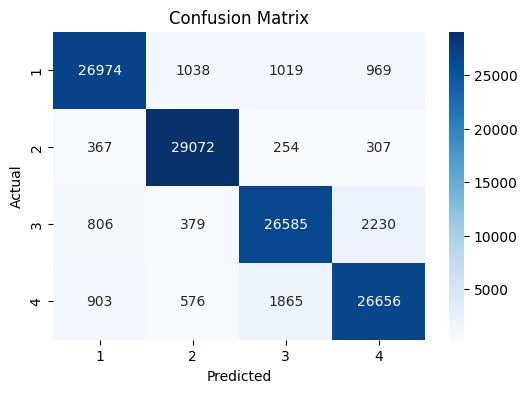

In [14]:
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()